# Can an LLM tell real from artificial poetry?

In [4]:
import os
import random
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import NormalDist
from sklearn.metrics import confusion_matrix, f1_score
from openai import OpenAI
from tqdm import tqdm

Si è scritto molto sulle capacità dei *Large Language Model* (LLM) di generare letteratura, ma poca attenzione ha ricevuto la domanda: un LLM può distinguere una poesia da dei versi generati artificialmente? Questo notebook tenta di dare una risposta. Per farlo, propongo un semplice compito di classificazione, in cui uno o più LLM classificano un insieme bilanciato di testi, di cui circa il 50% sono autentiche poesie e il restante 50% sono artificialmente generati.

Procedo nel modo schematizzato di seguito: ![schema del processo](notebook/llm-poesia-processo.png "Schema processo").
1. Raccogliamo un campione iniziale di poesie.
2. Utilizziamo questo campione per generare un elenco di argomenti e di parole chiave, nonché delle statistiche sulle principali caratteristiche del campione.
3. Utilizziamo l'elenco e le statistiche per generare un campione di poesie artificiali.
4. Chiediamo al LLM di classificare gli elementi del risultante insieme contentente sia poesie vere che artificiali, ripetendo l'esperimento sino a convergenza di qualche metrica.

## 1. Raccolta dataset
Raccogliamo un campione iniziale di $n > 96$ poesie, dove
$$n = \frac{Z^2\cdot{p}\cdot(1-p)}{E^2}$$
con:
- $Z$ = Z-score per un livello di confidenza del 95%
- $p$ = proporzione di esempi positivi = 50%
- $E$ = margine di errore pari a 0.10.

Le poesie sono state selezionate da un campione relativamente arbitrario di poeti elencati nella categoria Wikipedia [_Poeti italiani del XXI secolo_](https://it.wikipedia.org/wiki/Categoria:Poeti_italiani_del_XXI_secolo). Più o meno, ho inserito pescando a caso dall'elenco solo autori a me noti e che comunque ritenevo "noti" se non al grande pubblico a un pubblico non limitato agli addetti ai lavori. Di seguito il numero totale di poesie, e i loro autori.

In [15]:
with open("out/poems.json", "r") as f:
    poems = json.loads(f.read())["poems"]
df = pd.DataFrame(poems)
df = df.set_index("id", drop=True)
df["author"] = df["first_name"] + " " + df["last_name"]
df = df.drop(["first_name", "last_name"], axis=1)
authors = df.author.unique()
print("Totale poesie: {}".format(len(df)))
print("-"*25)
print("Numero autori inclusi: {}".format(len(authors)))
print("-"*25)
print(f"Autori inclusi:")
for author in authors:
    print("  {}".format(author))
df.to_csv("out/poems.csv")

Totale poesie: 119
-------------------------
Numero autori inclusi: 20
-------------------------
Autori inclusi:
  Sandro Penna
  Attilio Bertolucci
  Edoardo Sanguineti
  Cristina Campo
  Vittorio Sereni
  Patrizia Cavalli
  Mariangela Gualtieri
  Gilda Policastro
  Nanni Balestrini
  Luciano Erba
  Umberto Fiori
  Milo De Angelis
  Valentino Zeichen
  Michele Mari
  Maurizio Cucchi
  Andrea Zanzotto
  Dario Bellezza
  Giorgio Caproni
  Giovanna Bemporad
  Franco Fortini


Alcuni autori sono più rappresentati di altri.

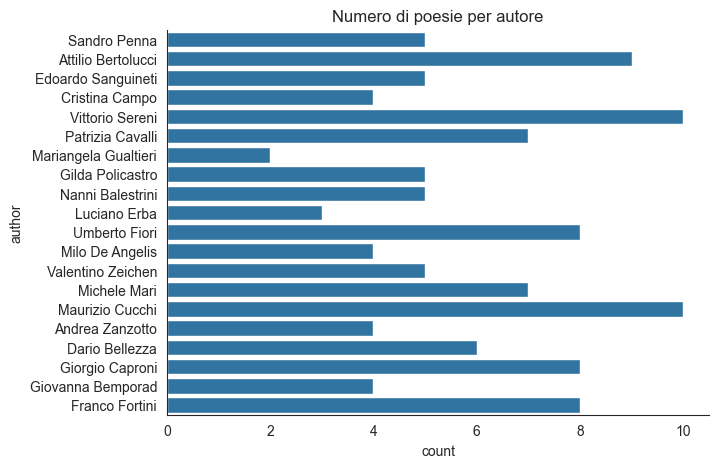

In [26]:
plt.figure(figsize=(7,5))
sns.set_style('white')
sns.countplot(df,y="author")
plt.title("Numero di poesie per autore")
sns.despine()
plt.show()

C'è molta dispersione nella lunghezza delle poesie, sia  in termini di caratteri che di versi

In [33]:
df["length"] = df["text"].apply(len)

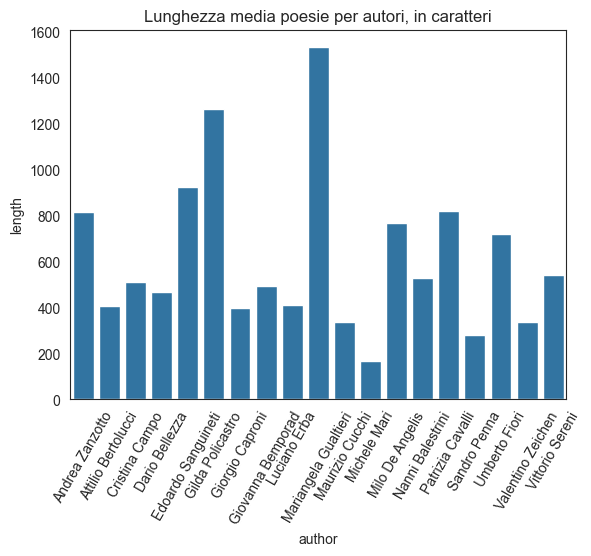

In [167]:
sns.barplot(x="author", y="length", data=df.drop(["title", "text"], axis=1).groupby("author").mean())
plt.xticks(rotation=60)
plt.title("Lunghezza media poesie per autori, in caratteri")
plt.show()

In [169]:
def num_verses(poem):
    return poem.count("\n")

df["num_verses"] = df["text"].apply(lambda poem: num_verses(poem))
verse_len_stats = df.drop(["title", "text"], axis=1).groupby("author").mean()["num_verses"].describe()
print("Lunghezze in versi: statistiche".upper())
verse_len_stats

LUNGHEZZE IN VERSI: STATISTICHE


count    19.000000
mean     15.998454
std       8.453505
min       4.700000
25%      12.000000
50%      13.666667
75%      16.775000
max      35.500000
Name: num_verses, dtype: float64

## Generazione poesie artificiali

In [30]:
client = OpenAI()
texts_for_topics = "\n***\n".join(list(df.text.values))
themes = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "system", "content": "Ti verrà fornita una lista di poemi separati da '\n***\n'. Il tuo compito è identificare una dozzina di temi ricorrenti. Rispondi con un semplice elenco di temi e parole chiave, senza commenti o spiegazioni. Non aggiungere nulla."},
    {"role": "user", "content": texts_for_topics}
  ]
)

themes = themes.choices[0].message.content
print(themes)

1. Nostalgia e rimpianto: "Ritornare", "compagnie di navigazione", "fanciulla bionda".
2. Solitudine e introspezione: "solo", "chiesa senza nome", "voci familiari".
3. Natura e paesaggi: "mare", "colli", "animali", "fiume", "vento".
4. Amore e relazioni: "amarezza", "ombra", "casa di mia madre", "amore mio".
5. Tempo e memoria: "tempo passato", "autunno", "cielo del meriggio".
6. Viaggio e movimento: "treno", "carri di fieno", "mare", "camminavo".
7. Guerra e sacrificio: "gioventù sacrificata", "guerra", "partigiana".
8. Vita quotidiana e gesti: "Voci calme del fiume", "scale", "seduti sulle panchine", "pane".
9. Morte e sofferenza: "sonno", "mortalità", "funerali".
10. Società e politica: "politici odiosi", "grande politica", "gesti della vita quotidiana".
11. Luce e ombre: "lume di candela", "ombre", "sole", "sera".
12. Identità e diversità: "chi è diverso", "comune", "differenza".


In [31]:
def create_poems():
    out = client.chat.completions.create(
      model="gpt-4o",
      messages=[
    {"role": "system", "content": "Sei un poeta italiano che scrive nel periodo 1960-2020. Il tuo compito è scrivere poesie"},
    {"role": "user", "content": f"Genera 10 poesie sui seguenti temi e parole chiave: {themes}. Le poesie devono essere lunghe da 5 a 35 versi con una media di 16 versi. Rispondi con un elenco di poesie separate da '***' senza commenti o spiegazioni. IMPORTANTE: assicurati di non aggiungere nulla se non i testi delle poesie e il separatore. Non aggiungere i temi e le parole chiave all'output."}
  ]
)

    return out.choices[0].message.content

In [32]:
artificial_poems = ""
for _ in range(10):
    artificial_poems += create_poems()

In [42]:
with open("texts/artificial/artificial_poems.txt", "w") as f:
    f.write(artificial_poems)

In [43]:
with open("texts//artificial/artificial_poems.txt") as f:
    artificial_poems = f.read()

In [44]:
real_poems_list = list(df.text.values)
artificial_poems_list = [poem.strip() for poem in artificial_poems.split("***")]
print(len(artificial_poems_list), len(real_poems_list))
artificial_poems_list = artificial_poems_list[:len(real_poems_list)]
print(len(artificial_poems_list), len(real_poems_list))

124 119
119 119


In [45]:
real_poems_for_pd = [{"text": poem, "label": 1} for poem in real_poems_list]
all_poems_for_pd = real_poems_for_pd + [{"text": poem, "label": 0} for poem in artificial_poems_list]

In [46]:
test_df = pd.DataFrame(all_poems_for_pd)

In [47]:
# Shuffling the text column
shuffled_df = test_df.sample(frac=1).reset_index(drop=True)
print(len(shuffled_df))

238


In [48]:
def get_predictions(texts):
    predictions = []
    for text in texts:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a text classification model."},
                {"role": "user", "content": f"Classify the following text into 1 or 0 where 1 is a poem written by a human, a recognized poet, and 0 is an artificially generated poem:\n\n{text}. Do not comment. Just output 1 or 0"}
            ]
        )
        prediction = int(response.choices[0].message.content.strip())
        predictions.append(prediction)
    return predictions

In [49]:
def plot_confusion_matrix():
    # Calculate and display the final confusion matrix for the last trial
    cf_matrix = confusion_matrix(shuffled_df['label'], shuffled_df['predicted_label'])
    
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1], cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [50]:
def run_trials(num_trials, variance_threshold, plot_cf_matrix=False):

    # Variables to store results
    accuracies = []
    f1_scores = []
    
    while True:
        for trial in tqdm(range(1, num_trials+1)):
            print("Trial: " + str(trial))
            
            # Get predictions for the shuffled texts
            predictions = get_predictions(shuffled_df['text'].tolist())
            
            # Add the predictions to the DataFrame
            shuffled_df['predicted_label'] = predictions
            
            # Calculate accuracy and F1-score
            accuracy = (shuffled_df['label'] == shuffled_df['predicted_label']).mean()
            f1 = f1_score(shuffled_df['label'], shuffled_df['predicted_label'], average='weighted')
            print(f"Accuracy: {accuracy}, F1: {f1}")
            # Append to results
            accuracies.append(accuracy)
            f1_scores.append(f1)
            if plot_cf_matrix:
                plot_confusion_matrix()
        
        # Calculate mean and standard deviation
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        mean_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)    
        # Check if variance is acceptable
        if std_accuracy**2 <= variance_threshold: #and std_f1**2 <= variance_threshold:
            break
        else:
            trials += 2  # Increment the number of trials
    
    # Print final results
    print("FINAL RESULTS")
    print("="*50)
    print(f"Mean Accuracy: {mean_accuracy}, Standard Deviation: {std_accuracy}")
    print(f"Mean F1 Score: {mean_f1}, Standard Deviation: {std_f1}")
    print(f"Total trials: {num_trials}")
    return accuracies, f1_scores

  0%|                   | 0/5 [00:00<?, ?it/s]

Trial: 1
Accuracy: 0.6596638655462185, F1: 0.6284332054815642


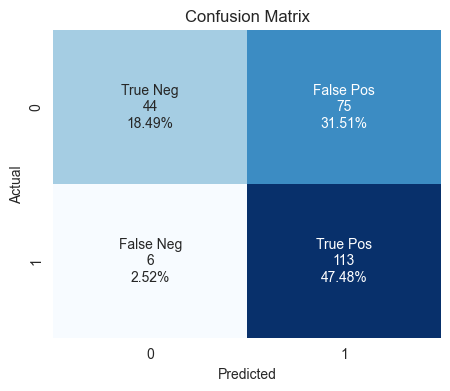

 20%|██        | 1/5 [02:03<08:15, 123.87s/it]

Trial: 2
Accuracy: 0.7184873949579832, F1: 0.698694329497572


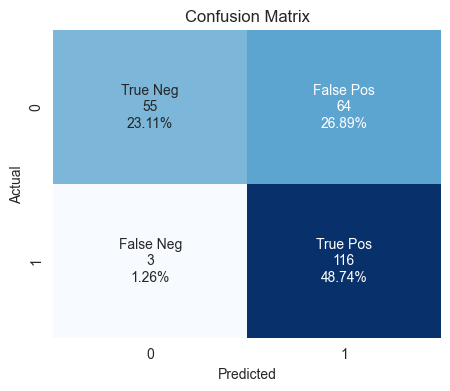

 40%|████      | 2/5 [04:13<06:21, 127.02s/it]

Trial: 3
Accuracy: 0.6932773109243697, F1: 0.668555294835842


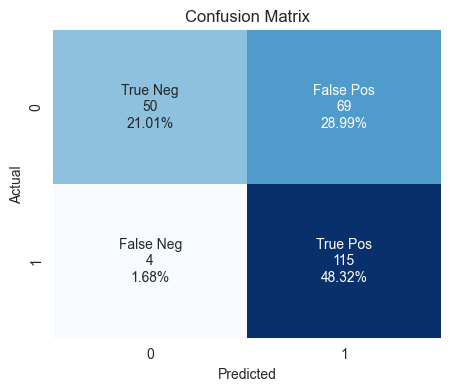

 60%|██████    | 3/5 [06:11<04:05, 122.90s/it]

Trial: 4
Accuracy: 0.6722689075630253, F1: 0.6392537893509522


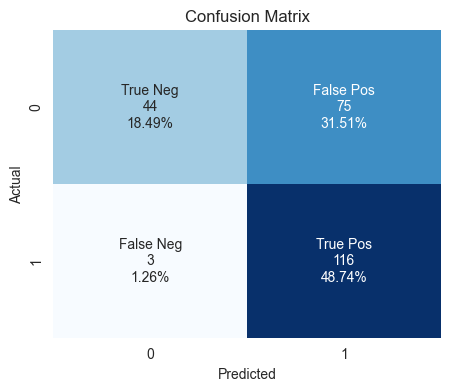

 80%|████████  | 4/5 [08:07<02:00, 120.45s/it]

Trial: 5
Accuracy: 0.6134453781512605, F1: 0.5669303797468355


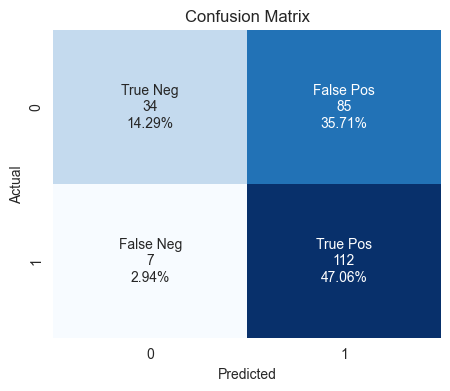

100%|██████████| 5/5 [10:06<00:00, 121.29s/it]

FINAL RESULTS
Mean Accuracy: 0.6714285714285715, Standard Deviation: 0.03519393544768389
Mean F1 Score: 0.6403733997825533, Standard Deviation: 0.044120854504529954
Total trials: 5


([0.6596638655462185,
  0.7184873949579832,
  0.6932773109243697,
  0.6722689075630253,
  0.6134453781512605],
 [0.6284332054815642,
  0.698694329497572,
  0.668555294835842,
  0.6392537893509522,
  0.5669303797468355])

In [51]:
variance_threshold = 0.03
num_trials = 5
run_trials(num_trials, variance_threshold, plot_cf_matrix=True)

È interessante vedere come gli errori sono quasi interamente falsi positivi. I falsi negativi sono quasi sempre residuali. Il modello tende a essere "generoso": come se nel dubbio preferisse etichettare un testo come autentico.